In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## AE latent space

In [2]:
# AE model
class AE(nn.Module):
    def __init__(self, input_features=376,  hidden_size1=256, hidden_size2=128, z_dim=3, 
                drop_enc1=0.3, drop_enc2=0.2, drop_enc3=0.3, 
                drop_dec1 = 0.3, drop_dec2=0.2, drop_dec3=0.2):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(nn.BatchNorm1d(input_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_enc1),
                                        nn.Linear(input_features, hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_enc2),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_enc3),
                                        nn.Linear(hidden_size2, z_dim))
        self.decoder = nn.Sequential(nn.BatchNorm1d(z_dim, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_dec1),
                                        nn.Linear(z_dim, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_dec2),
                                        nn.Linear(hidden_size2, hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_dec3),
                                        nn.Linear(hidden_size1, input_features))

        
    def encode(self, x):
        z = self.encoder(x)
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

### Prepare data

In [3]:
coarse_factors = [32]
Directory = f"data"
variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

full_len_in = nz*(len(variables)-1)
len_in = nz

model_number = 11
tmin=1
tmax=62+1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print('using cuda : ', torch.cuda.is_available())

path_times_train = f'data/test_train_times/times_train_{model_number}.csv'
path_times_test = f'data/test_train_times/times_test_{model_number}.csv'
isFile = os.path.isfile(path_times_train) and os.path.isfile(path_times_test)
#print(isFile)

if not isFile :
    utils.split_times(tmin,tmax,model_number)
    
train_times = pd.read_csv(path_times_train).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(path_times_test).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_, _, input_test, _ = utils.make_train_test_ds(coarse_factors, full_len_in, train_times, test_times, Directory)
input_test = input_test.reshape(-1,len(variables)-1,nz)

for i in range(len(variables)-1):
    input_test[:,i] -= torch.mean(input_test[:,i])
    input_test[:,i] /= torch.std(input_test[:,i])

In [33]:
ae_model = AE(input_features=nz)
ae_model.load_state_dict(torch.load('explo/models/{}_ae_net.pt'.format(variables[0]), map_location=torch.device(device)))
ae_model.to(device)
for params in ae_model.parameters():
    params.requires_grad = False

Y = []
for i in range(len(variables)-1):
    Y.append(ae_model.encode(input_test[:500,i]).detach().cpu().numpy())

In [38]:
Z_u = Y[0]
Z_u[:,0].shape

(500,)

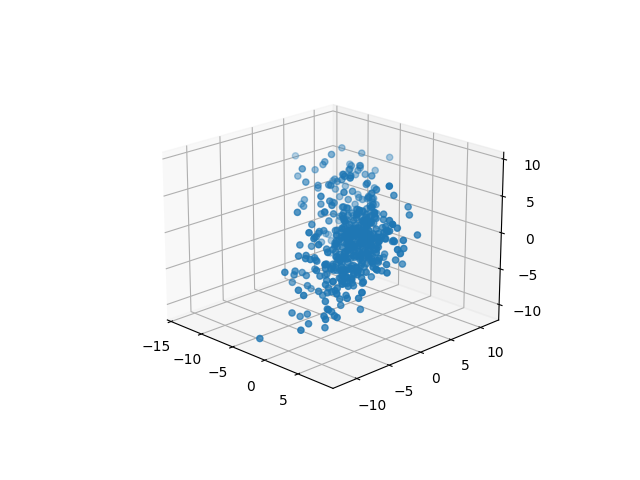

In [39]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(Z_u[:,0], Z_u[:,1], Z_u[:,2])
ax.view_init(elev=20., azim=-45)
plt.show()


/var/folders/mj/nb723j_d64xgxpvtpndr7t0w0000gn/T/ipykernel_58258/1711525633.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


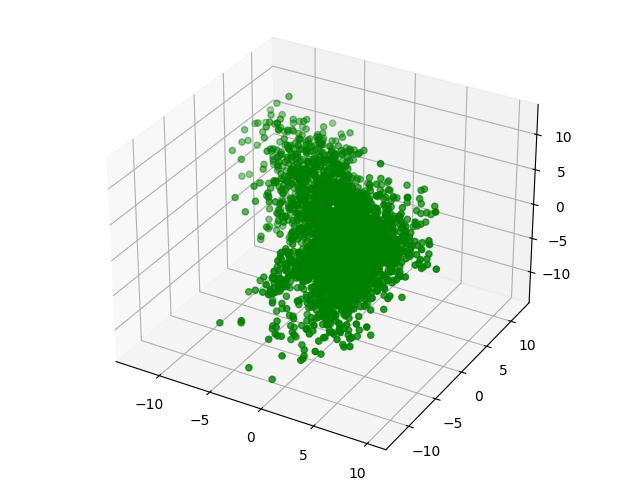

In [28]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
plot_geeks = ax.scatter(Z_u[:,0], Z_u[:,1], Z_u[:,2], color='green')

plt.show()